## Binary Search Tree

How does a search tree work? What are its properties?

In [5]:
# Toy dataset

towns = {
    0: {'name': 'Romanshorn', 'population': 11556, 'latitude': 47.56586, 'longitude': 9.37869},
    1: {'name': 'Amriswil', 'population': 14313, 'latitude': 47.54814, 'longitude': 9.30327},
    2: {'name': 'Arbon', 'population': 15459, 'latitude': 47.51360, 'longitude': 9.42999},
    3: {'name': 'Weinfelden', 'population': 11893, 'latitude': 47.56638, 'longitude': 9.10588},
    4: {'name': 'Frauenfeld', 'population': 26093, 'latitude': 47.55856, 'longitude': 8.89685},
    5: {'name': 'Kreuzlingen', 'population': 22788, 'latitude': 47.645837,'longitude': 9.178608},
    6: {'name': 'Egnach', 'population': 4897, 'latitude': 47.54565, 'longitude': 9.37864},
}

### BST Nodes
A binary node with two children, a key, and a value (payload).

In [2]:
class BstNode():
    """Invariant: All keys in left subtree are <= key, all keys in right subtree are >= key."""
    def __init__(self, key, value):
        self.left = None
        self.right = None
        self.key = key
        self.value = value

### Building a Tree

Use the list of elements sorted by the search dimension - always use the median of the remaining list as the next node. Build the tree recursively.

In order to find the median, we first need to create a list of all (population, id) tuples sorted by population.

In [3]:
# Lets sort the tuples
sorted_by_population = []
for id,town in towns.items():
    tuple_population_id = (town['population'], id)
    sorted_by_population.append(tuple_population_id)

sorted_by_population.sort()
sorted_by_population

[(4897, 6),
 (11556, 0),
 (11893, 3),
 (14313, 1),
 (15459, 2),
 (22788, 5),
 (26093, 4)]

In [4]:
def build_bst(sorted_tuples, lower, upper):
    """Include all elements in sorted_tuples from lower to upper indices (inclusive)."""
    if lower > upper:
        return None
    median_index = (lower + upper) // 2
    median_element = sorted_tuples[median_index]
    node = BstNode(median_element[0], median_element[1])
    node.left = build_bst(sorted_tuples, lower, median_index - 1)
    node.right = build_bst(sorted_tuples, median_index + 1, upper)
    return node

node = build_bst(sorted_by_population, 0, len(sorted_by_population)-1)

### Tree Traversal
Let's walk the tree in-order.

#### Generators
We could print all elements as we go; easier is to use `yield` and `yield from` instead, such that the tree traversal function becomes a _generator_. A python generator is something that can be iterated over (with a `for`-loop). Computation of each element in the iteration is deferred until the loop actually requests it. The generator internally keeps track of the iteration state; in our case: where in the tree we were when the previous element was requested.

The `yield` statement will "return" an element to one iteration request, and execution will continue after the yield statement for the next request.

The `yield from` statement is similar, but will exhaust the generator it is called for, before continuing after the statement for any subsequent invocation.

Read more on [`yield` on python.org](https://docs.python.org/3/reference/expressions.html#yield-expressions).

In [5]:
def walk_tree(tree):
    if tree is None:
        return
    yield from walk_tree(tree.left)
    yield tree
    yield from walk_tree(tree.right)

for node in walk_tree(node): print(node.key, node.value, towns[node.value]['name'])

4897 6 Egnach
11556 0 Romanshorn
11893 3 Weinfelden
14313 1 Amriswil
15459 2 Arbon
22788 5 Kreuzlingen
26093 4 Frauenfeld


### Visualize

Let's use graphviz to render a visualization of the tree.

Note: you may need to restart the kernel to use updated packages.


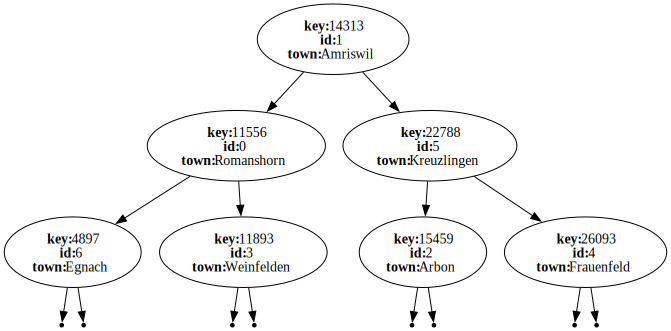

In [17]:
%pip install graphviz
import graphviz

def render_tree(graph, node, nuller=""):
    """Renders the tree in graphviz."""
    if node is None:
        # In order to have separate Nil-nodes, we need to create artificially
        # named nodes with unique names. We use the 'nuller' parameter to create
        # these, which is the left/right-path down from the root.
        graph.node(nuller, "", shape="point")
        return nuller
    
    id = str(node.key)
    graph.node(id, f"< <B>key:</B> {id}<BR/><B>id:</B> {str(node.value)}<BR/><B>town:</B> {towns[node.value]['name']} >")
    left_key = render_tree(graph, node.left, nuller + "l")
    graph.edge(id, left_key)
    right_key = render_tree(graph, node.right, nuller + "r")
    graph.edge(id, right_key)
    return id

dot = graphviz.Digraph("Population Search Tree")
render_tree(dot, node)
dot

### Querying

Now let's query the tree index! We want to retrieve nodes _in-order_, similar to the tree walk above. Again, recursion and yield makes the implementation pretty neat.
  * If the search key (or lower bound of the search range) is less or equal than a node's `key`, we keep searching to the `left`.
  * If the node's key matches the query, we include this node's value in the result set.
  * If the search key (or upper bound of the search range) is greater or equal than the node's `key`, we keep searching to the `right`.
  * If the node is `None`, we were called for a non-existing node (the child of a leaf) and should simply return.

In [ ]:
def tree_search(node, lower, upper):
    """Traverses tree in-order from lower to upper key."""
    if node is None:
        return  # reached a leaf node
    if lower <= node.key:
        # return elements on our left
        yield from tree_search(node.left, lower, upper)
    if lower <= node.key <= upper:
        yield node  # return this node
    if node.key <= upper:
        # return elements on our right
        yield from tree_search(node.right, lower, upper)

for node in tree_search(node, 5000, 13000):
    entity = towns[node.value]
    print(entity['name'], entity['population'])


Romanshorn 11556
Weinfelden 11893


## More Dimensions

 Suppose we want to efficiently find out which entities in our geodatabase are within the latitude/longitude rectangle between 46.2386N8.5203E and 46.4193N8.7309E. We could build a range index as above on either latitude or longitude, but either of those would return a thousands of matching entities which we'd need to intersect in order to get the handful we want.

 ### Exercise
 Build a mono-dimensional index for longitude and find out how many entities exist within 8.5203 and 8.7309.
 
 ### Two-dimensional Index
 If we want to build an index that allows efficient querying along more than one dimension, things become slightly more complex. One option is to use a [Quadtree](https://en.wikipedia.org/wiki/Quadtre): instead of just storing `left` and `right` subtrees, our tree node could store four children, for example `ne`, `se`, `sw`, `ne`. When querying the tree, we select the matching subtree by comparing the query coordinates to the node's key, which is the lat/lng of the node's entity. We can then descend into the matching quadrant.

 Quadtrees work well for two dimensions, and you can imagine that an Octtree can be used to partition three-dimensional space. A generalization of that scheme are [k-d-Trees](https://en.wikipedia.org/wiki/K-d_tree), which can be used to partition by any number (the _k_ in _k_-dimensional) of dimensions. Instead of increasing the number of children per node, k-d-trees stick to a single partition, and instead cycles through the dimensions on each tree level.

 For example, for our latitude-longitude problem, the root node would have two children dividing the latitude dimension, whereas its grandchildren would divide the longitude dimension and the great-grandchildren again divide the latitude. By passing the _depth_ of the tree along any recursive function, we can determine the dimension being dividided by computing `depth % k`.

 #### Building a k-d-Tree
 A big challenge is finding the median entity in the current dimension when building the tree. In the one-dimensional case, all that was needed was a sorted list, for which we could easily compute the middle element of each sub-range of the list using bisection. For more than one dimension, this becomes tricky, even if we maintained a copy of the list sorted by each dimension:

<p float="left">
  <img src="https://docs.google.com/drawings/d/e/2PACX-1vRnpT_tavr-5qGnYQvB_Emc0EA4iJchrFavnuqrscm0YKJQyc-Fp_ZUNRYttaRwyVxb9AY09-dl2qFf/pub?w=482&h=368" />
  <img src="https://docs.google.com/drawings/d/e/2PACX-1vQrJ3_UUmAoGs4yTo_0E7XxKG96oqRqNMOEO8J8vrXyEpjL-US9KzXY7sSuc_NBBX_t_COBC7IJdnM9/pub?w=324&h=304" />
</p>

Finding the first latitude split point (long horizontal blue in the figure) is easy if we have a list of all points sorted by latitude: we select the median by computing the midpoint of the entire list, rounding down to the (blue) `3`. 

The second level splits happen along the longitude (vertical red lines). But how would we find the midpoint of the remaining points? Even if we do have a point list sorted by longitude, we don't know which of the points are still valid candidates, as some have been already moved to the other side of the latitude split.

### Preparing the Data
Instead of just a single key, each element has a list of keys, one for each dimension.

For a spatial index using latitude and longitude, the dimensionality is 2.

In [6]:
# Goal: Town tuples of the form (keys, value), where keys specifies the key for each dimension.
# Example:     0: {'name': 'Romanshorn', 'population': 11556, 'latitude': 47.56586, 'longitude': 9.37869},
# tuples = [
#   ((47.56586, 9.37869), 0),
#   ((47.23, 10.108), 3),
# ]
lat_lng_tuples = [((town['latitude'], town['longitude']), id) for id, town in towns.items()]
lat_lng_tuples

[((47.56586, 9.37869), 0),
 ((47.54814, 9.30327), 1),
 ((47.5136, 9.42999), 2),
 ((47.56638, 9.10588), 3),
 ((47.55856, 8.89685), 4),
 ((47.645837, 9.178608), 5),
 ((47.54565, 9.37864), 6)]

### Build

The node of a kd-tree is really not different from any BST node, and we could simply re-use what we have.

Otherwise, building the tree is considerably more complex than the single-dimension case. While finding out which dimension we are on is not hard, the trouble comes from the fact that we cannot maintain a sorted tuple-list and use bisection to simply partition. Instead, we need a different approach to tell at each step which elements are covered by the node to be created:

In our example, we create a fresh list `filtered` that is the subset of the passed-in tuples that match the bounds passed in. This is not so efficient as we effectively create a copy of (cumulatively) the entire dataset _on each tree level_, amounting to $\mathcal{O}(n\cdot\log{}n)$ memory. We could probably do better by simply providing a filtered view of the original.

#### Median Finding
Also, finding the ideal element that perfectly bisects the remaining elements is hard as we'd need to sort the elements to find the median. While [efficient median-finding algorithms](https://en.wikipedia.org/wiki/Selection_algorithm}) exist, we choose a simpler approach and just use the last element as our pivot, hoping that on average, this should work fine. That assumption would be wrong if the tuples were sorted by either direction, as then the last element would be a bad choice and turn our tree into a vine...

In [7]:
import copy

class KdNode:
    """A node in a kd-tree."""
    def __init__(self, key, value):
        self.key = key
        self.value = value
        self.left = None
        self.right = None

def is_within_bounds(keys, bounds):
    """Returns True if all of the keys are within the given corresponding bounds."""
    # keys: (47.56638, 9.10588)
    # bounds: [(-90, 90), (-180, 180)]
    """Checks on all dimensions in bounds whether it contains keys."""
    for (lower, upper), key in zip(bounds, keys):
        if not lower <= key <= upper:
            return False
    return True

def filter_tuples(tuples, bounds):
    """Returns the list of the subset of tuples that are within the bounds given."""
    # Example: tuple: ((47.56638, 9.10588), 3)
    # FIXME: avoid copying the tuples and create a filtered view instead (use filter built-in).
    filtered = []
    for tuple in tuples:
        keys, value = tuple
        if is_within_bounds(keys, bounds):
            filtered.append(tuple)
    return filtered

def find_median(tuples):
    """Selects a median element, removes it from tuples, and returns it."""
    if not tuples:
        return None
    # Just use the last element - FIXME this is a bad choice if the dataset is
    # sorted in one of the dimensions, consider a randomized or sample-based 
    # median instead.
    index = len(tuples) - 1
    return tuples.pop(index)

def build_kd_tree(tuples, bounds, depth=0):
    """Recursively builds a kd-tree over tuples. Each tuple is expected to have a key-tuple at its first position whose
    dimensionality is the same as the bounds dimensionality."""
    filtered = filter_tuples(tuples, bounds)
    median = find_median(filtered)
    if not median:
        return None

    node = KdNode(median[0], median[1])

    # perform magic recursion by adjusting bounds in subtrees
    # Example: Median is ((47.56638, 9.10588), 3)
    # Depth is 0 
    # -> Dimension_index is 0 (splitting on latitude direction)
    # Bounds: [(-90, 90), (-180, 180)]
    # Left-bounds = [(-90, 47.56638), (-180, 180)]
    # Right-bounds = [(47.56638, 90), (-180, 180)]
    dimension_index = depth % len(bounds)
    lower, upper = bounds[dimension_index]
    key = node.key[dimension_index]

    left_bounds = copy.copy(bounds)
    left_bounds[dimension_index] = (lower, key)
    node.left = build_kd_tree(filtered, left_bounds, depth+1)

    right_bounds = copy.copy(bounds)
    right_bounds[dimension_index] = (key, upper)
    node.right = build_kd_tree(filtered, right_bounds, depth+1)
    
    return node

bounds = [(-90, 90), (-180, 180)]
kd_tree = build_kd_tree(lat_lng_tuples, bounds)
    

### Visualizing, Walking and Searching the KD-Tree
The kd-tree is a BST, so we can visualize and walk it as usual. Note that the order of the tree no longer corresponds to a _natural sort order_ as the order is only with respect to each level's dimension.

In [38]:
for node in walk_tree(kd_tree):
    print(node.key, node.value, towns[node.value]['name'])

(47.5136, 9.42999) 2 Arbon
(47.54565, 9.37864) 6 Egnach
(47.55856, 8.89685) 4 Frauenfeld
(47.56638, 9.10588) 3 Weinfelden
(47.645837, 9.178608) 5 Kreuzlingen
(47.54814, 9.30327) 1 Amriswil
(47.56586, 9.37869) 0 Romanshorn


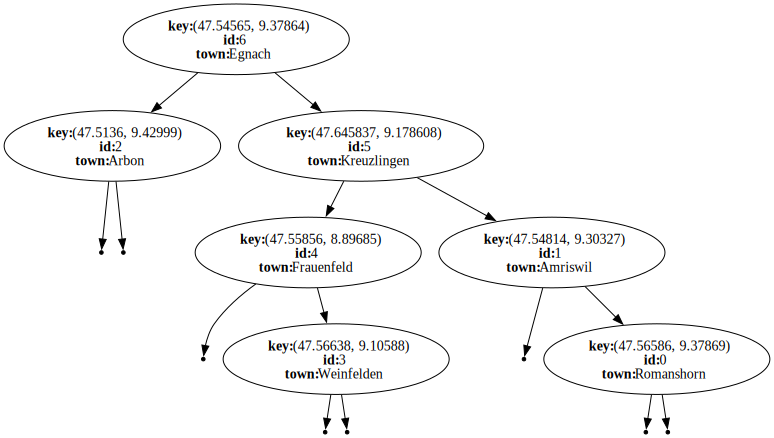

In [39]:
dot = graphviz.Digraph("Population Search Tree")
render_tree(dot, kd_tree)
dot

Searching is again more complex than with the simple BST:

The decision to search or skip the subtrees is solely based on the node's dimension. Inclusion of the node itself however needs to check all dimensions, as we could well be within the range of the node's dimension but outside the search interval on other dimensions.

In [8]:
def search_kd_tree(node, bounds, depth=0):
    """Searches a kd-tree and yields elements within bounds."""
    # Example: key is (47.56638, 9.10588)
    # Depth is 0 (splitting on latitude direction)
    # Bounds: [(-90, 90), (-180, 180)]

    if node is None:
        return
    
    # For deciding to search the subtrees, we only need to consider
    # the current dimension_index.
    dimension_index = depth % len(bounds)
    key = node.key[dimension_index]
    lower, upper = bounds[dimension_index]

    # If lower <= key, the search interval extends to our left.
    if lower <= key:
        yield from search_kd_tree(node.left, bounds, depth+1)
    
    # For inclusion, we need to check all dimensions, not just the current
    # dimension_index.
    if is_within_bounds(node.key, bounds):
        yield node
    
    # If key <= upper, the search interval extends to our right.
    if key <= upper:
        yield from search_kd_tree(node.right, bounds, depth+1)

# Search for all towns west of Weinfelden.
weinfelden = towns[3]
print(f"West of {weinfelden['name']}:")
results = search_kd_tree(kd_tree, [(-90, 90), (-180, weinfelden['longitude'])])
for node in results:
    print(node.key, node.value, towns[node.value]['name'])

# Search for all towns south of Arbon.
arbon = towns[2]
print(f"South of {arbon['name']}:")
for node in search_kd_tree(kd_tree, [(-90, arbon['latitude']), (-180, 180)]):
    print(node.key, node.value, towns[node.value]['name'])

# All towns in Oberthurgau
lower_left = (47.51282, 9.24036)
upper_right = (47.57679, 9.46421)
print("Towns in Oberthurgau:")
for node in search_kd_tree(kd_tree, [(lower_left[0], upper_right[0]), (lower_left[1], upper_right[1])]):
    print(node.key, node.value, towns[node.value]['name'])


West of Weinfelden:
(47.55856, 8.89685) 4 Frauenfeld
(47.56638, 9.10588) 3 Weinfelden
South of Arbon:
(47.5136, 9.42999) 2 Arbon
Towns in Oberthurgau:
(47.5136, 9.42999) 2 Arbon
(47.54565, 9.37864) 6 Egnach
(47.54814, 9.30327) 1 Amriswil
(47.56586, 9.37869) 0 Romanshorn


### Alternative Building Strategies

Since we no longer require medians and rely on luck (or statistics) for our tree to be balanced, we might as well just insert nodes as we iterate over them. We choose a pivot element from the list of tuples and use it as the root. Then we pick more elements and decide the correct leaf position for it by following the nodes from the root.

In [14]:
%pip install tqdm
%pip install ipywidgets
%pip install widgetsnbextension

from tqdm.auto import tqdm
def insert_node(parent, node, depth=0):
    keys = parent.key
    dimension_index = depth % len(keys)
    key = keys[dimension_index]
    if node.key[dimension_index] <= key:
        if parent.left is None:
            parent.left = node
        else:
            insert_node(parent.left, node, depth + 1)
    else:
        if parent.right is None:
            parent.right = node
        else:
            insert_node(parent.right, node, depth + 1)   

def build_kd_tree2(tuples, max_count):
    tuples = iter(tuples)
    key, value = next(tuples)
    tree = KdNode(key, value)
    for key, value in tqdm(tuples, total=max_count-1):
        node = KdNode(key, value)
        insert_node(tree, node)
    return tree

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [15]:
kd_tree_2 = build_kd_tree2(lat_lng_tuples, len(lat_lng_tuples))

  0%|          | 0/6 [00:00<?, ?it/s]

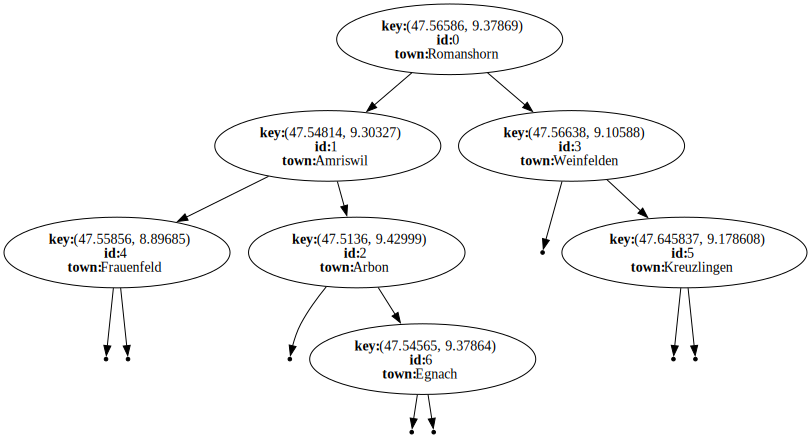

In [18]:
dot = graphviz.Digraph("Population Search Tree")
render_tree(dot, kd_tree_2)
dot